In [1]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

In [2]:
class_N = {}
N_class = {}
with open('C:/Users/kurt_/food-101/food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

# Method to generate directory-file map. 
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

# Method to recursively copy a directory.  
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

# Train files to ignore. 
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('C:/Users/kurt_/food-101/food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.    
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('C:/Users/kurt_/food-101/food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

# Method to load and resize images.  
def load_images(path_to_imgs):
  resize_count = 0
  
  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)
  
  return np.array(all_imgs), np.array(all_classes)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [4]:
# Method to generate train-test files. 
def gen_train_test_split(path_to_imgs='C:/Users/kurt_/food-101/food-101/images', target_path='C:/Users/kurt_/food-101/food-101'):
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    train_path = os.path.join(target_path, 'train')
    test_path = os.path.join(target_path, 'test')
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    copytree(path_to_imgs, train_path, ignore=ignore_test)
    copytree(path_to_imgs, test_path, ignore=ignore_train)


# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test

# Generate train-test files. 
if not os.path.isdir('C:/Users/kurt_/food-101/food-101/test') and not os.path.isdir('C:/Users/kurt_/food-101/food-101/train'):
    gen_train_test_split()  
    len_train = len(os.listdir('C:/Users/kurt_/food-101/food-101/train'))
    len_test = len(os.listdir('C:/Users/kurt_/food-101/food-101/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('C:/Users/kurt_/food-101/food-101/train'))
    len_test = len(os.listdir('C:/Users/kurt_/food-101/food-101/test'))
    print(len_train,len_test)


train and test folders already exists.
101 31


In [6]:
tensorflow.keras.backend.clear_session()

n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = 'C:/Users/kurt_/food-101/food-101/train'
test_data = 'C:/Users/kurt_/food-101/food-101/test'
train_samples = 75750
test_samples = 25250

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit(train_gen, steps_per_epoch= train_samples // batch_size, validation_data= test_gen, validation_steps= test_samples // batch_size, epochs=30, callbacks=[csv_logger, checkpointer])

model.save('model_trained_101class.hdf5')


Found 101000 images belonging to 101 classes.
Found 101000 images belonging to 101 classes.
87910968/87910968 [==============================] - 178s 2us/step


C:\Users\kurt_\anaconda3\envs\tensorflowgpuden\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
4734/4734 [==============================] - 1300s 272ms/step - loss: 4.8865 - accuracy: 0.0682 - val_loss: 4.1127 - val_accuracy: 0.2283
Epoch 2/30
4734/4734 [==============================] - 1032s 218ms/step - loss: 3.8400 - accuracy: 0.2536 - val_loss: 2.9559 - val_accuracy: 0.4296
Epoch 3/30
4734/4734 [==============================] - 950s 201ms/step - loss: 3.1134 - accuracy: 0.3821 - val_loss: 2.3819 - val_accuracy: 0.5337
Epoch 4/30
4734/4734 [==============================] - 935s 197ms/step - loss: 2.6974 - accuracy: 0.4606 - val_loss: 2.0595 - val_accuracy: 0.5966
Epoch 5/30
4734/4734 [==============================] - 900s 190ms/step - loss: 2.4220 - accuracy: 0.5118 - val_loss: 1.8584 - val_accuracy: 0.6369
Epoch 6/30
4734/4734 [==============================] - 876s 185ms/step - loss: 2.2265 - accuracy: 0.5521 - val_loss: 1.7021 - val_accuracy: 0.6648
Epoch 7/30
4734/4734 [==============================] - 876s 185ms/step - loss: 2.0715 - accuracy: 0.5801 - va

In [7]:
class_map_101 = train_gen.class_indices
class_map_101

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

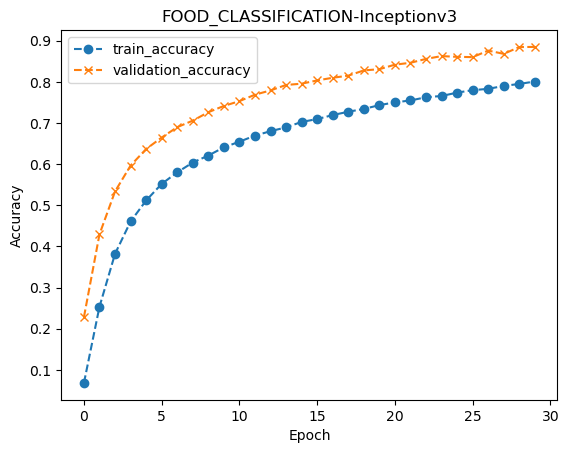

In [15]:
import matplotlib.pyplot as plt

# Varsayılan matplotlib stili
plt.style.use('default')

# Kodun geri kalanını buraya ekleyin
# Plot training-accuracy & validation-accuracy.
plt.title('FOOD_CLASSIFICATION-Inceptionv3')
plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()



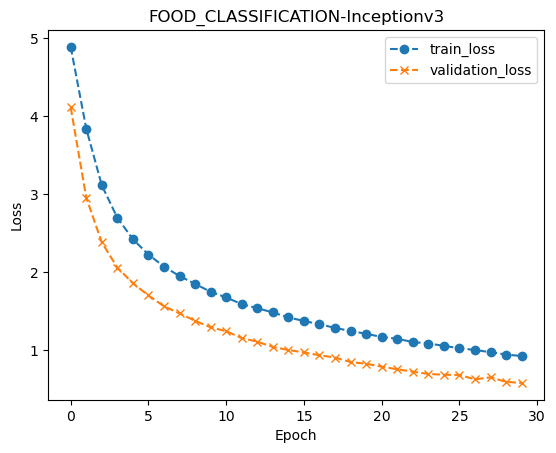

In [16]:
import matplotlib.pyplot as plt

# Varsayılan matplotlib stili
plt.style.use('default')

# Kodun geri kalanını buraya ekleyin
# Plot training-loss & validation-loss.
plt.title('FOOD_CLASSIFICATION-Inceptionv3')
plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()


In [27]:
import wget

# Downloading some test images.
image_urls = {
    'cupcakes.jpg': 'https://www.hersheyland.com/content/dam/hersheyland/en-us/recipes/recipe-images/27_hersheys-perfectly-chocolate-cupcakes-11-18.jpeg?im=Resize=(1920)',
    'frenchfries.jpg': 'https://turkishstylecooking.com/wp-content/uploads/2015/10/dondurulmus_patates_kizartmasi1.jpg',
    'pizza.jpg': 'https://www.eatingwell.com/thmb/k3RhYf4XhAeqAejYjdInOlSOp6I=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/gettyimages-1124303516-36413b5bf61f45f1b7d18d90000b56b7.jpg',
    'garlicbread.jpg': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4zI_5uIYLTRedCrEgIQ5uUtT3Ese2EBQobOL5DdvurQ&s',
    'strawberryshortcake.jpg': 'https://www.how-tasty.com/wp-content/uploads/2020/10/miniatura-min-300x300.jpg',
    'speghetticarbonara.jpg': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQam_rbwWTMnp83PdhonN6EcAKGc2CudbnWSFzlztJk4A&s'
}

for filename, url in image_urls.items():
    try:
        wget.download(url, filename)
        print(f"{filename} adlı dosya başarıyla indirildi.")
    except Exception as e:
        print(f"{filename} adlı dosya indirilirken bir hata oluştu: {e}")



100% [............................................................................] 108920 / 108920cupcakes.jpg adlı dosya başarıyla indirildi.
100% [............................................................................] 438977 / 438977frenchfries.jpg adlı dosya başarıyla indirildi.
100% [............................................................................] 172735 / 172735pizza.jpg adlı dosya başarıyla indirildi.
100% [..............................................................................] 15779 / 15779garlicbread.jpg adlı dosya başarıyla indirildi.
strawberryshortcake.jpg adlı dosya indirilirken bir hata oluştu: HTTP Error 403: Forbidden
100% [..............................................................................] 12245 / 12245speghetticarbonara.jpg adlı dosya başarıyla indirildi.


1/1 [==============================] - 0s 17ms/step


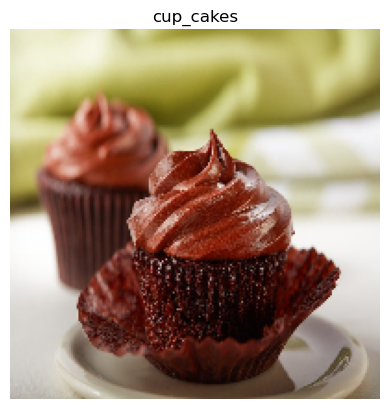

1/1 [==============================] - 0s 17ms/step


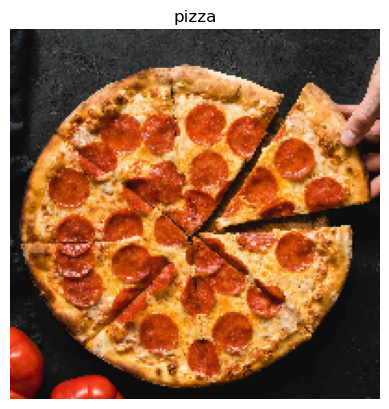

1/1 [==============================] - 0s 25ms/step


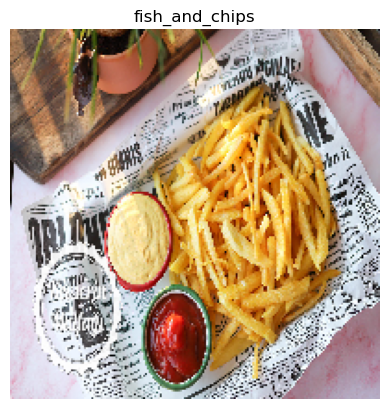

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


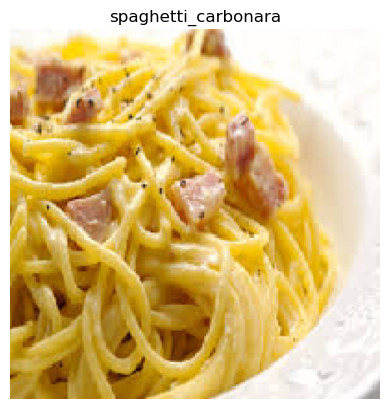

In [30]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(200, 200))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = img / 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    pred_value = foods_sorted[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = ['cupcakes.jpg', 'pizza.jpg', 'frenchfries.jpg', 'garlicbread.jpg', 'strawberryshortcake.jpeg', 'speghetticarbonara.jpg']
predict_class(model_best, images, True)

In [68]:
tensorflow.keras.backend.clear_session()
print("Loading the model..")
model = load_model('best_model_101class.hdf5',compile = False)
# Get model layers
layers = [layer.output for layer in model.layers[1:11]]
layer_names = []

activations_output = models.Model(inputs=model.input, outputs=layers)

for layer in model.layers[1:11]:
    layer_names.append(layer.name)

print(layer_names)
print(len(model.layers))

Loading the model..
['conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d']
315


1/1 [==============================] - 0s 61ms/step


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

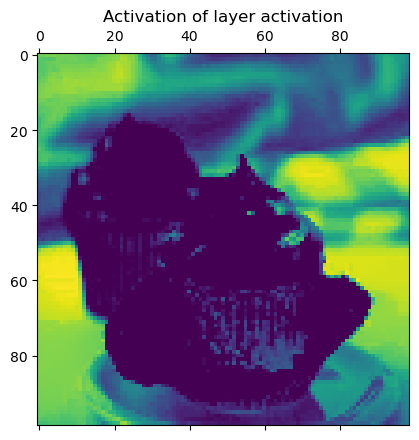

<Figure size 800x800 with 0 Axes>

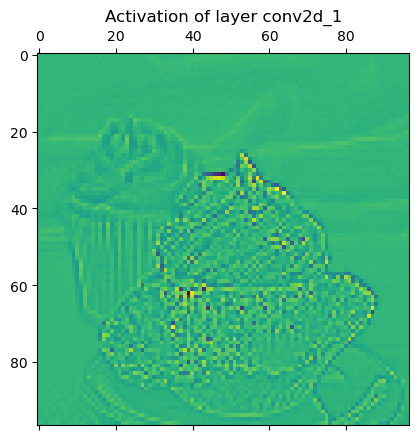

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

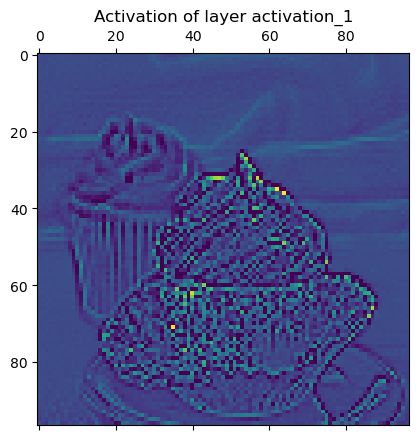

<Figure size 800x800 with 0 Axes>

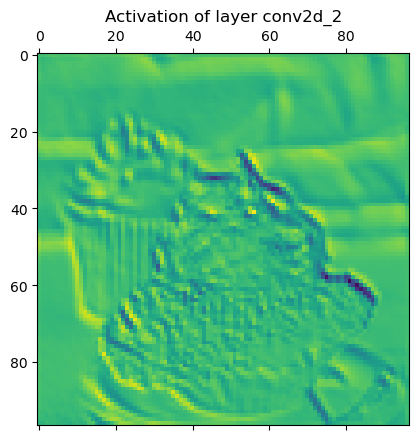

<Figure size 800x800 with 0 Axes>

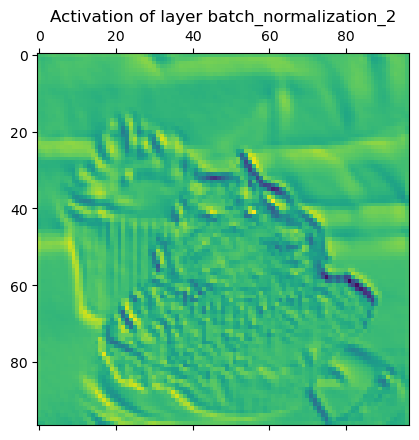

<Figure size 800x800 with 0 Axes>

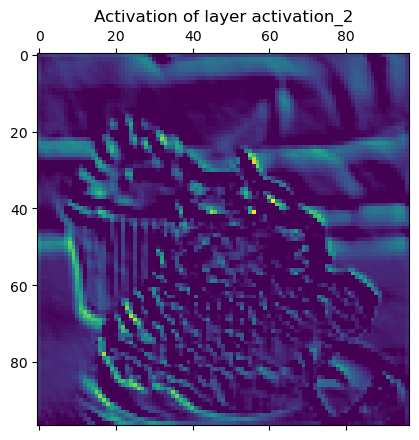

<Figure size 800x800 with 0 Axes>

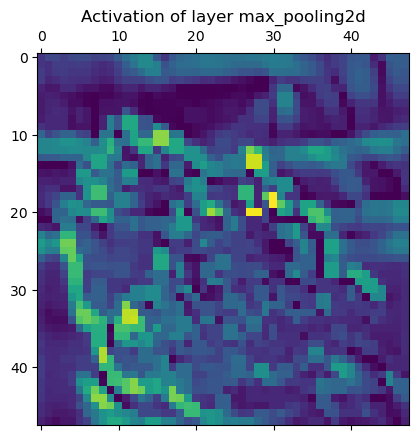

1/1 [==============================] - 0s 6ms/step


<Figure size 800x800 with 0 Axes>

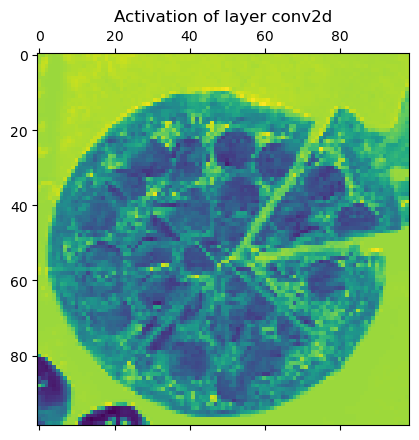

<Figure size 800x800 with 0 Axes>

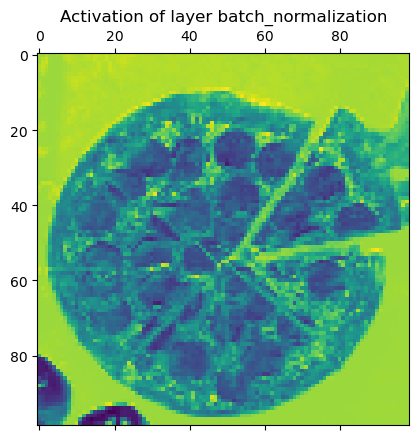

<Figure size 800x800 with 0 Axes>

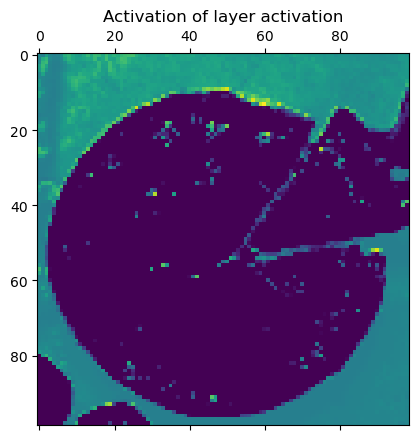

<Figure size 800x800 with 0 Axes>

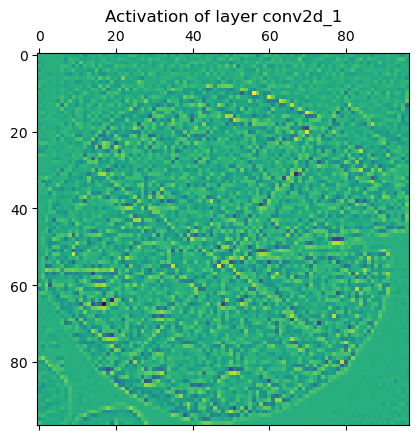

<Figure size 800x800 with 0 Axes>

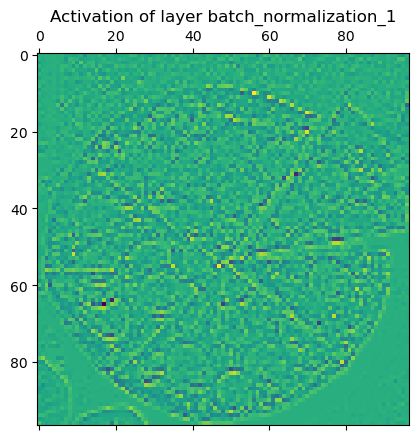

<Figure size 800x800 with 0 Axes>

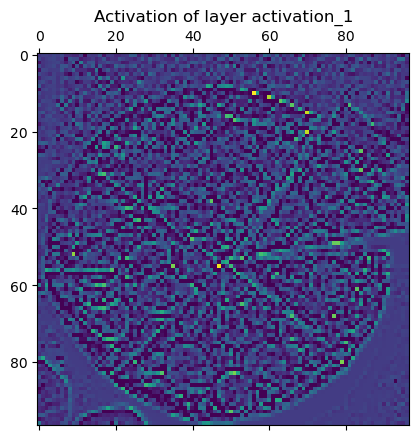

<Figure size 800x800 with 0 Axes>

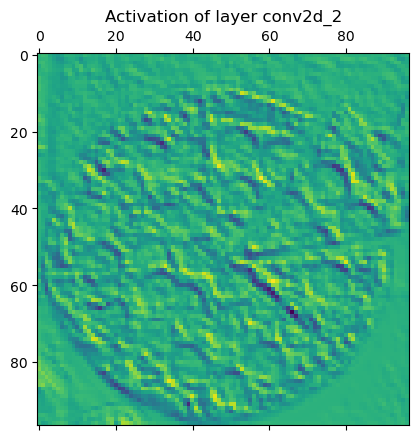

<Figure size 800x800 with 0 Axes>

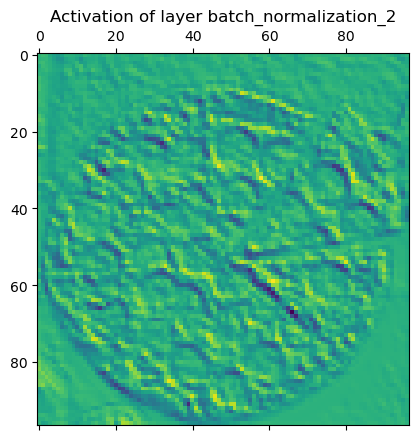

<Figure size 800x800 with 0 Axes>

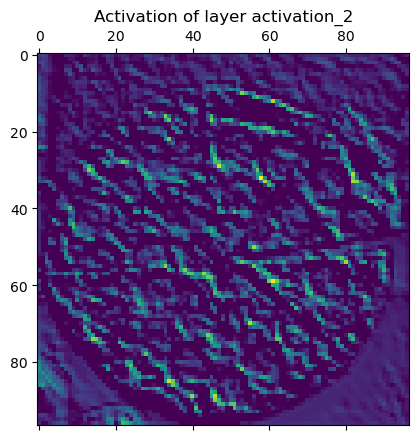

<Figure size 800x800 with 0 Axes>

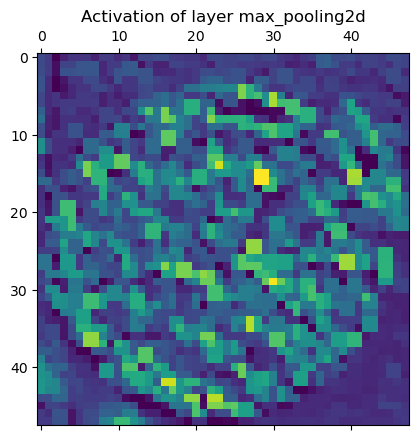

1/1 [==============================] - 0s 15ms/step


<Figure size 800x800 with 0 Axes>

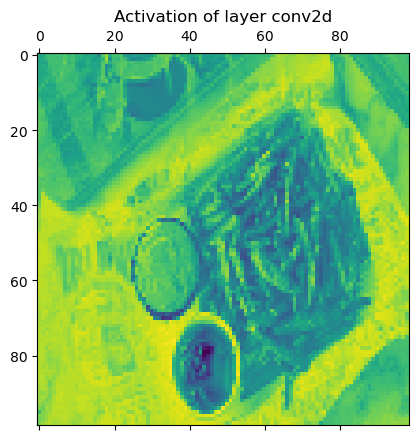

<Figure size 800x800 with 0 Axes>

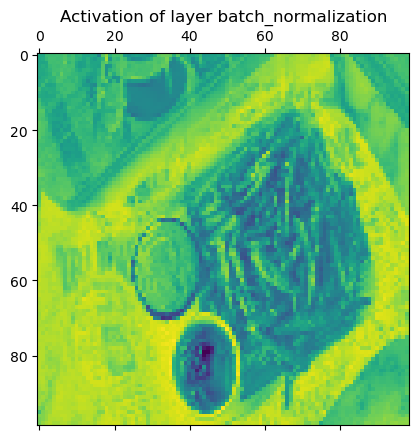

<Figure size 800x800 with 0 Axes>

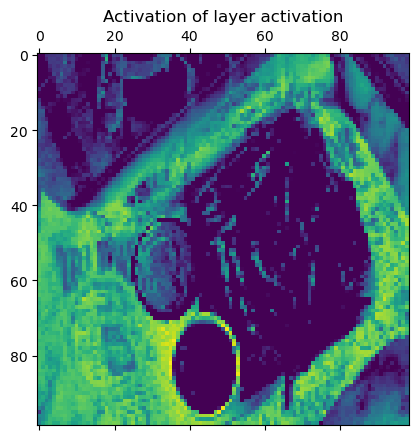

<Figure size 800x800 with 0 Axes>

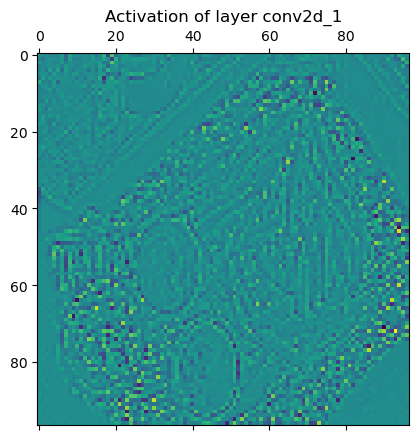

<Figure size 800x800 with 0 Axes>

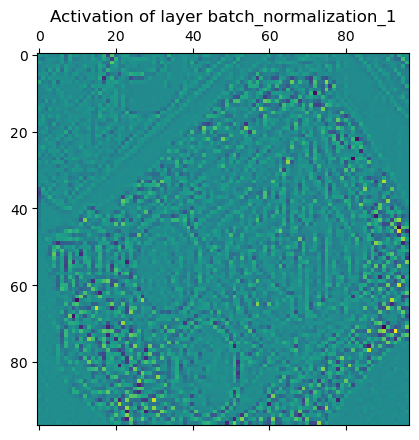

<Figure size 800x800 with 0 Axes>

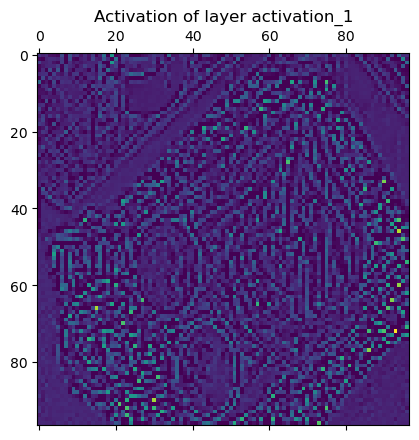

<Figure size 800x800 with 0 Axes>

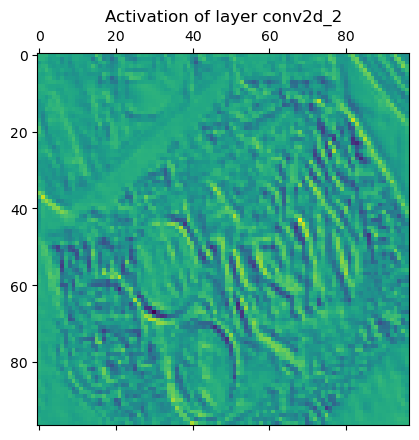

<Figure size 800x800 with 0 Axes>

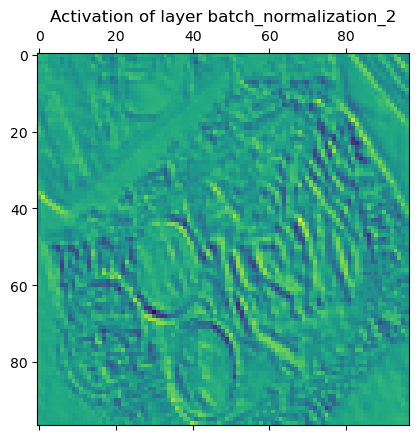

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

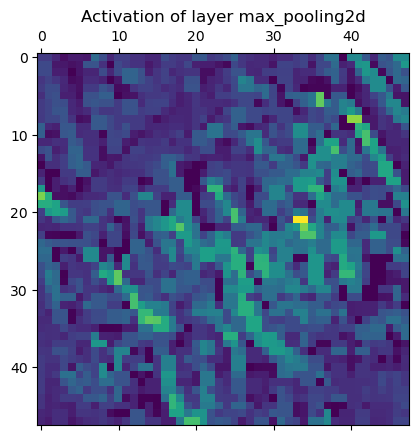

1/1 [==============================] - 0s 12ms/step


<Figure size 800x800 with 0 Axes>

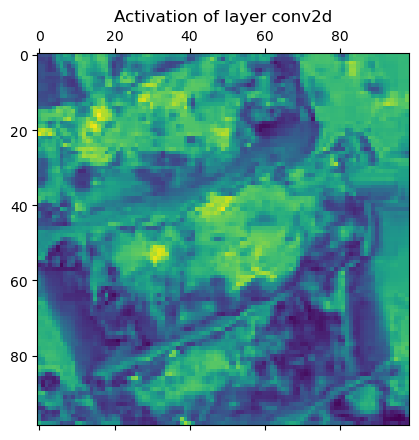

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

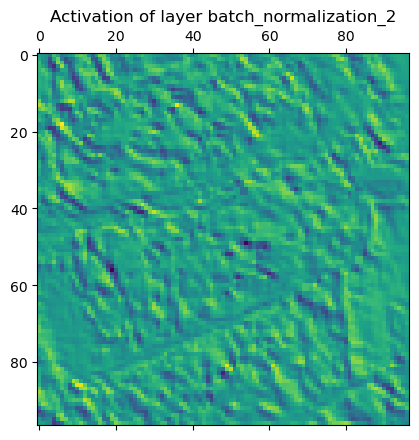

<Figure size 800x800 with 0 Axes>

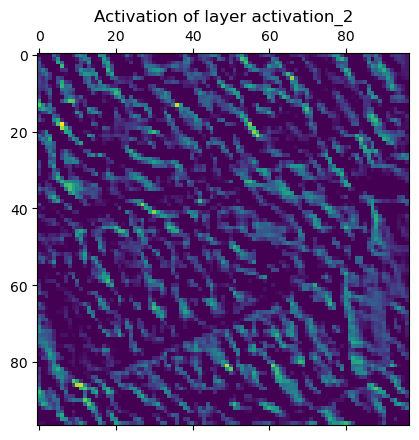

<Figure size 800x800 with 0 Axes>

1/1 [==============================] - 0s 28ms/step


<Figure size 800x800 with 0 Axes>

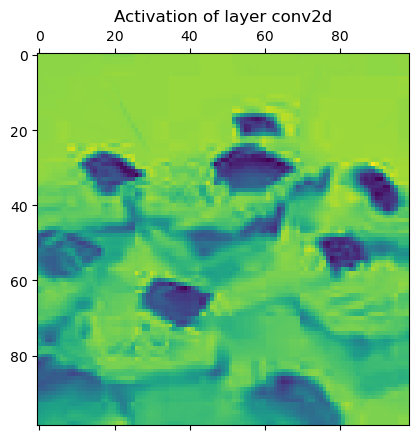

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

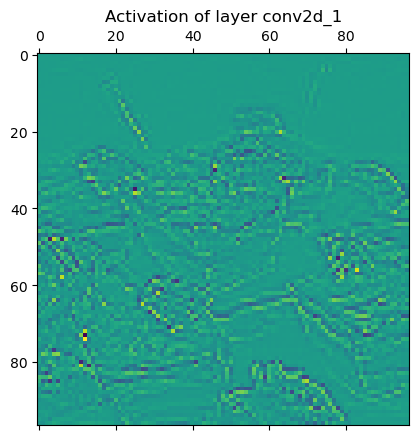

<Figure size 800x800 with 0 Axes>

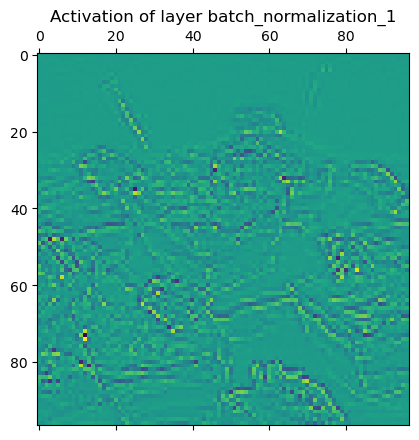

<Figure size 800x800 with 0 Axes>

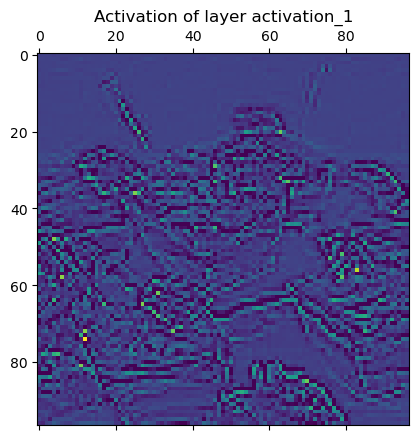

<Figure size 800x800 with 0 Axes>

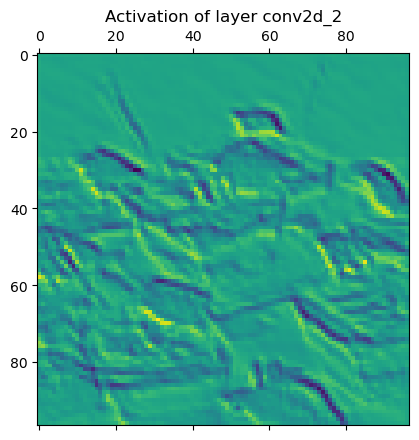

<Figure size 800x800 with 0 Axes>

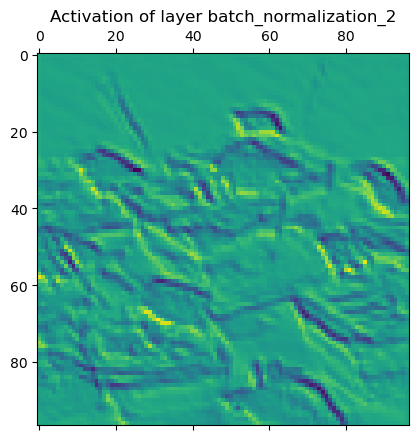

<Figure size 800x800 with 0 Axes>

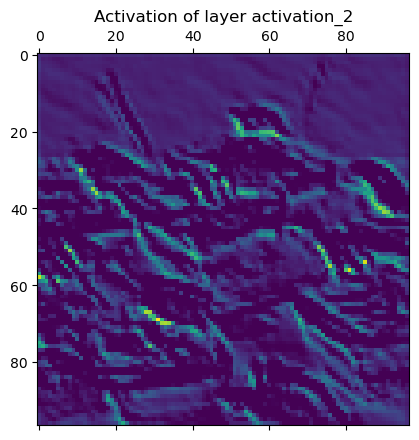

<Figure size 800x800 with 0 Axes>

1/1 [==============================] - 0s 16ms/step


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

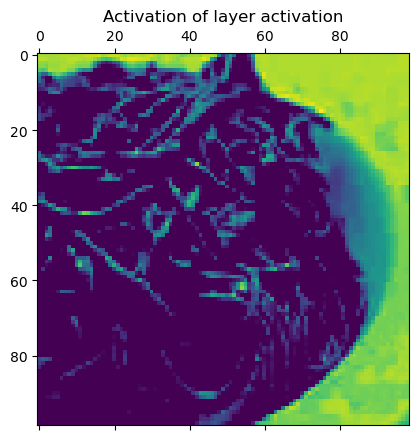

<Figure size 800x800 with 0 Axes>

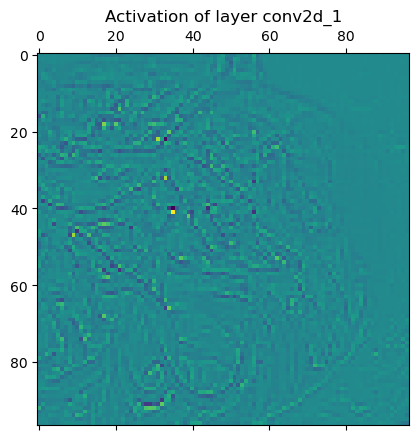

<Figure size 800x800 with 0 Axes>

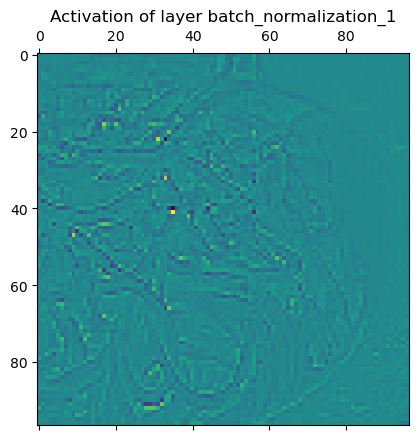

<Figure size 800x800 with 0 Axes>

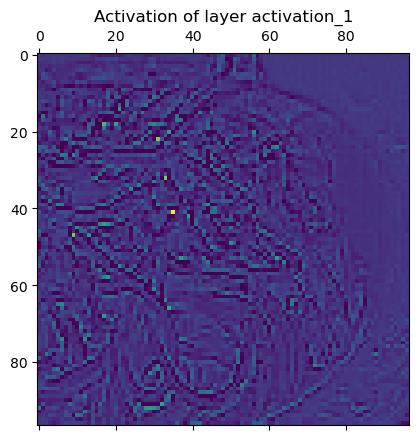

<Figure size 800x800 with 0 Axes>

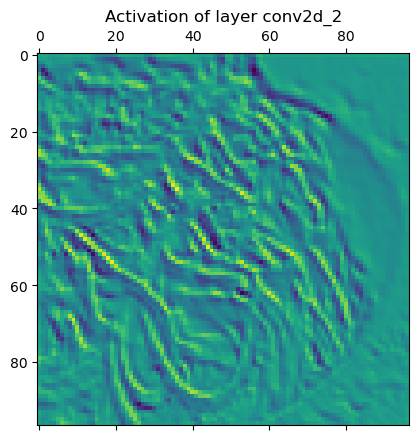

<Figure size 800x800 with 0 Axes>

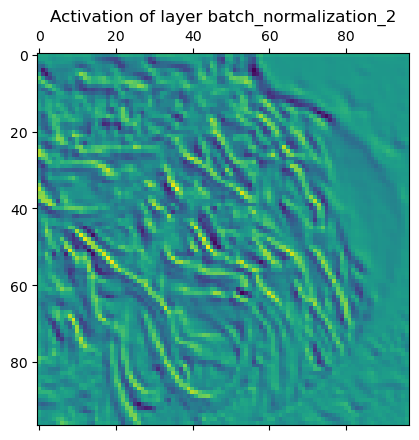

<Figure size 800x800 with 0 Axes>

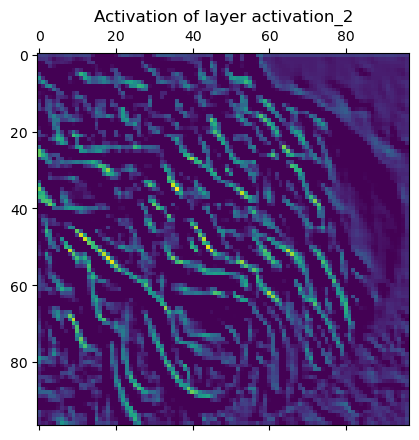

<Figure size 800x800 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def test_images(model, images):
    for img_path in images:
        img = image.load_img(img_path, target_size=(200, 200))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.

        activations = activations_output.predict(img)
        for i, activation in enumerate(activations):
            plt.figure(figsize=(8, 8))
            plt.matshow(activation[0, :, :, 0], cmap='viridis')
            plt.title(f'Activation of layer {layer_names[i]}')
            plt.show()

images = ['cupcakes.jpg', 'pizza.jpg', 'frenchfries.jpg', 'garlicbread.jpg', 'strawberryshortcake.jpeg', 'speghetticarbonara.jpg']
test_images(model, images)


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


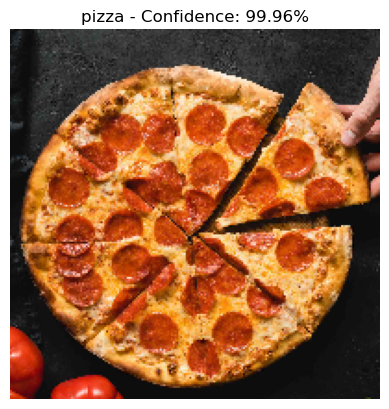

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


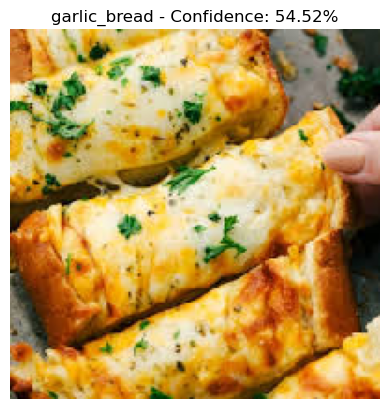

1/1 [==============================] - 0s 16ms/step


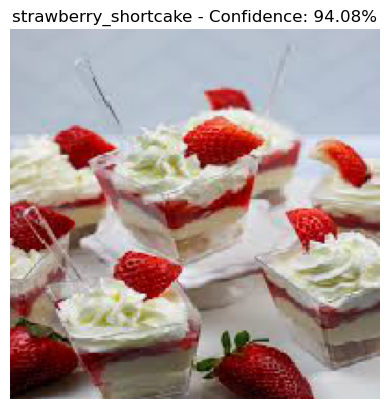

1/1 [==============================] - 0s 22ms/step


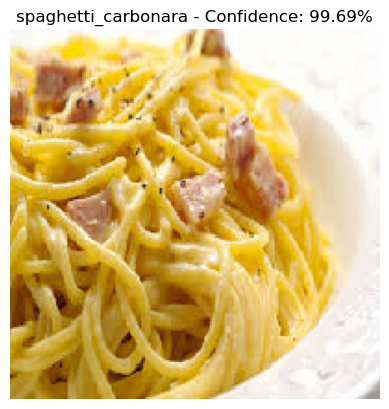

In [71]:
def predict_class(model, images, show=True):
    for img_path in images:
        img = image.load_img(img_path, target_size=(200, 200))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.

        pred = model.predict(img)
        index = np.argmax(pred)
        foods_sorted.sort()
        pred_value = foods_sorted[index]

        # Get the confidence score for the predicted class
        confidence_score = pred[0][index] * 100

        if show:
            plt.imshow(img[0])
            plt.axis('off')
            plt.title(f'{pred_value} - Confidence: {confidence_score:.2f}%')
            plt.show()

images = ['cupcakes.jpg', 'pizza.jpg', 'frenchfries.jpg', 'garlicbread.jpg', 'strawberryshortcake.jpeg', 'speghetticarbonara.jpg']
predict_class(model, images)


In [72]:
pip install google_images_download

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
    --------------------------------------- 0.2/10.5 MB 3.1 MB/s eta 0:00:04
   - -------------------------------------- 0.3/10.5 MB 3.8 MB/s eta 0:00:03
   - -------------------------------------- 0.4/10.5 MB 3.8 MB/s eta 0:00:03
   - -------------------------------------- 0.5/10.5 MB 3.1 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/10.5 MB 3.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/10.5 MB 3.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/10.5 MB 3.1 MB/s eta 0:00:04
   --- ------------------------------------ 0.9/10.5 MB 3.2 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/10.5 MB 2.9 MB/s eta 0:00:04
   ---- ----------------------------------- 1.1/10.5 MB 2.9 MB/s eta 0:00:04
   ---- ----------------------------------- 1.2/10.5 MB 2.

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 22ms/step


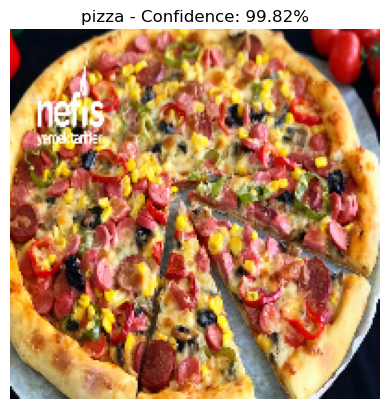

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


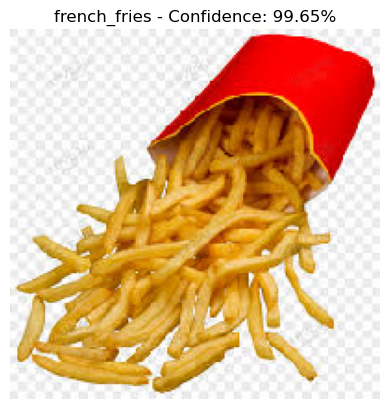

1/1 [==============================] - 0s 16ms/step


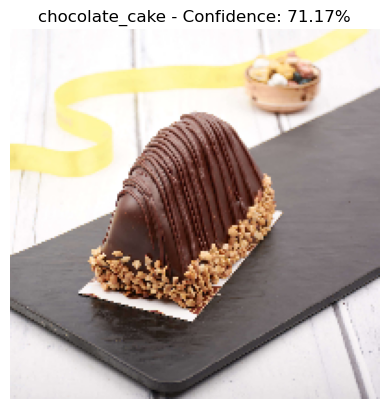

1/1 [==============================] - 0s 31ms/step


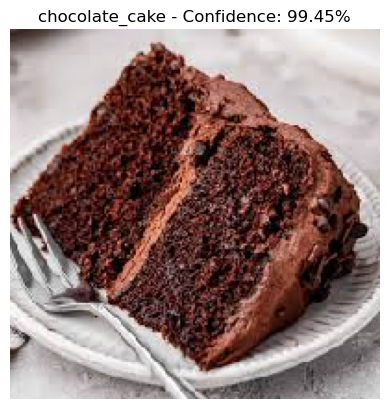

1/1 [==============================] - 0s 22ms/step


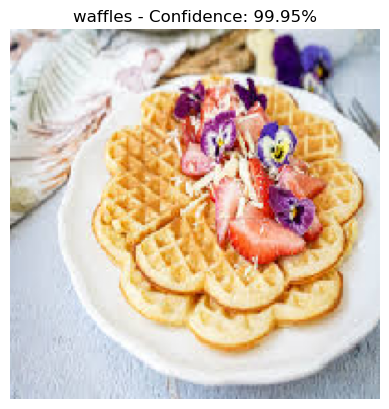

In [113]:
import os

# Hedef klasör
target_folder = "C:/Users/kurt_/kontrolresimleri"

# İndirilen resimler
downloaded_images = ['pizza2.png', 'pizza.jpg','tiramisu.jpeg','frenchfries.jpeg','malagapastadeneme.jpg','choccolatecake.jpeg','waffle.jpeg']

# Resimlerin tam dosya yolları
image_paths = [os.path.join(target_folder, img) for img in downloaded_images]

# Tahmin edilen sınıflar ve güven skorlarını almak için fonksiyonu tekrar kullanma
predict_class(model, image_paths)

